## Utilities Functions

In [ ]:
import numpy as np
import pickle
import os
import os.path




def load_from_full_dataset(full_dataset_path, capture_date,rx_name,prefix=None):
    src=full_dataset_path

    if prefix is None: 
        dataset_path = '{}pkl_wifi_{}/dataset_{}_node{}.pkl'.format(src,capture_date,capture_date,rx_name)
    else:
        dataset_path = '{}pkl_wifi_{}_{}/dataset_{}_node{}.pkl'.format(src,prefix,capture_date,capture_date,rx_name)
   
    if os.path.isfile(dataset_path) :
        with open(dataset_path,'rb') as f:
            dataset = pickle.load(f)
    else:
            dataset = None
#             print('Not Found')
#             print(dataset_path)
    return dataset


def load_compact_pkl_dataset(dataset_path,dataset_name):
    with open(dataset_path+dataset_name+'.pkl','rb') as f:
        dataset = pickle.load(f)
    return dataset


def shuffle(vec1,vec2,seed = 0):
    np.random.seed(0)
#     print(vec1.shape[0],vec2.shape[0])
    shfl_indx = np.arange(vec1.shape[0])
    np.random.shuffle(shfl_indx)
    shfl_indx = shfl_indx.astype('int')
    vec1 = vec1[shfl_indx]
    vec2 = np.copy(vec2[shfl_indx])
    return vec1,vec2


def norm(sig_u):
    if len(sig_u.shape)==3:
        pwr = np.sqrt(np.mean(np.sum(sig_u**2,axis = -1),axis = -1))
        sig_u = sig_u/pwr[:,None,None]
    if len(sig_u.shape)==2:
        pwr =  np.sqrt(np.mean(np.sum(sig_u**2,axis = -1),axis = -1))
        sig_u = sig_u/pwr
    # print(sig_u.shape)
    return sig_u

def split3(vec,n1,n2):
    vec1 = vec[0:n1]
    vec2 = vec[n1:n1+n2]
    vec3 = vec[n1+n2:]
    return vec3,vec1,vec2

def split_set3(st,f1,f2):
    [sig,txid] = st

    n_samples  = sig.shape[0]
    n1 = int(f1*n_samples)
    n2 = int(f2*n_samples)

    sig1,sig2,sig3 = split3(sig,n1,n2)
    txid1,txid2,txid3 = split3(txid,n1,n2)
    st1 = [sig1,txid1]
    st2 = [sig2,txid2]
    st3 = [sig3,txid3]
    return st1,st2,st3 

def get_node_indices(tx_name_list,node_name_list):
    op_list = []
    for tx in tx_name_list:
        if tx in node_name_list:
            op_list.append(node_name_list.index(tx))
        else:
            op_list.append(None)
    return op_list
    
def parse_nodes(dataset,node_list,seed = 0):
    cat_sig = []
    cat_txid = []
    data = dataset['data']
    
    
    for i,node in enumerate(node_list):
        if (not node  is  None) and  node < len(data):
            cat_sig.append(data[node])
            cat_txid.append(np.ones( (data[node].shape[0]) )*i)
    cat_sig = np.concatenate(cat_sig)
    cat_txid = np.concatenate(cat_txid)
    np.random.seed(seed)
    cat_sig,cat_txid = shuffle(cat_sig,cat_txid)
    cat_sig = norm(cat_sig)
    return (cat_sig,cat_txid)

def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def prepare_txid_and_weights(st,n):
    sig,txid = st
    txid_oh = to_categorical(txid,n)
    stat= np.sum(txid_oh,axis=0)
    cls_weights = np.max(stat,axis=0)/stat 
    cls_weights = cls_weights.tolist()
    augset = [sig,txid,txid_oh,cls_weights]
    return augset

def prepare_dataset(dataset,tx_name_list,val_frac=0.1, test_frac=0.1):
    tx_list = get_node_indices(tx_name_list,dataset['node_list'])
    all_set = parse_nodes(dataset,tx_list,seed = 0)
    train_set,val_set,test_set = split_set3(all_set,val_frac, test_frac)
    train_augset = prepare_txid_and_weights(train_set,len(tx_list))
    val_augset = prepare_txid_and_weights(val_set,len(tx_list))
    test_augset = prepare_txid_and_weights(test_set,len(tx_list))
    return train_augset,val_augset,test_augset


def create_dataset_impl(tx_list,rx_list,capture_date_list,max_sig=None,equalized_list=[0],full_dataset_path = 'data/',op_dataset_file = None):
    dataset = {}
    dataset['tx_list'] = tx_list
    dataset['rx_list'] = rx_list
    dataset['capture_date_list']=capture_date_list
    dataset['equalized_list'] = equalized_list
    dataset['max_sig'] = max_sig
    
    n_tx = len(tx_list)
    n_rx = len(rx_list)
    n_day = len(capture_date_list)
    n_eq = len(equalized_list)
    
    prefix_lut = [None,'eq']
    
    prefix_list = [prefix_lut[tt] for tt in  equalized_list]
    
    dataset['data'] = [ [ [ [ [ ] for _ in range(n_eq)] for _ in range(n_day) ] for _ in range(n_rx) ]  for _ in range(n_tx)     ]
    
    
    missing_rx_dict = {}
    
    missing_files = False

    
    with open('IdSig_info.pkl','rb') as f:
        IdSig_info=pickle.load(f)
    
    slc = slice(None,max_sig)
    for day_i,capture_date in enumerate(capture_date_list):
        for rx_i,rx_train in enumerate(rx_list):
            for eq_i,prefix in enumerate(prefix_list):
                tdataset = load_from_full_dataset(full_dataset_path,capture_date,rx_train,prefix=prefix)
                if not tdataset is None:
                    for tx_i,tx in enumerate(tx_list):
                        if tx in tdataset['node_list']:
                            tx_indx = tdataset['node_list'].index(tx)
                            dataset['data'][tx_i][rx_i][day_i][eq_i]= tdataset['data'][tx_indx][slc]  
                        else:
                            dataset['data'][tx_i][rx_i][day_i][eq_i]=np.zeros((0,256,2))
                else:
                    missing_rx_name =rx_list[rx_i]  
                    eq_val = equalized_list[eq_i]
                    IdSig_info_sub  = IdSig_info[eq_val][capture_date]
                    if missing_rx_name  in IdSig_info_sub.keys():
                            missing_files = True
                            if not eq_val in  missing_rx_dict.keys():
                                missing_rx_dict[eq_val]={}
                            if not capture_date in  missing_rx_dict[eq_val].keys():
                                missing_rx_dict[eq_val][capture_date]=[]
                            missing_rx_info  = IdSig_info_sub[missing_rx_name]
                            missing_rx_dict[eq_val][capture_date].append(   (missing_rx_info['name'], missing_rx_info['link'],missing_rx_info['size']) )

    
    if missing_files:
        ii=1
        total_file_sizes = 0
        print('You have missing files that you need to download.')
        
        for eq_k  in missing_rx_dict.keys():  
            if len(missing_rx_dict[eq_val])>0:
                print('')
                if eq_k==0:
                    print('You need to download the following files for the non equalized dataset')
                else:
                    print('You need to download the following files for the equalized dataset')
                
                print('')
                
                for date_k  in missing_rx_dict[eq_k].keys():  
                    for missing_rx in missing_rx_dict[eq_val][date_k]:
                        print('{}) Name: {} , Size: {} MB'.format(ii,missing_rx[0],missing_rx[2]/1e6))
                        total_file_sizes=total_file_sizes+missing_rx[2]
                        ii=ii+1
                print('Links:')
                for date_k  in missing_rx_dict[eq_k].keys():  
                    for missing_rx in missing_rx_dict[eq_val][date_k]:
                        print('https://drive.google.com/u/0/uc?export=download&id={}'.format(missing_rx[1]))               
        print('')
        print('You need to dowlnoad {} GB'.format(total_file_sizes/1e9))
        print('Note the following:')
        print('1) The non-equalized and eqalized files need to be downloaded in different fodlers because they share the same exact names')
        print('2) The  non-equalized folders needs to be grouped by date and equalization using the same structure as the following google drive folder')
        print('https://drive.google.com/drive/folders/1r8cd4zZ7fwvN_iiyI_uDKbIFGZve49lw?usp=sharing')
        print('3) If you have already downloaded the files make sure that the full dataset path is configured correctly.')
        dataset = None
    else:
        if not op_dataset_file is None:
            with open(op_dataset_file,'wb') as f:
                pickle.dump(dataset,f)
                print('Dataset saved in {}'.format(op_dataset_file))

    return dataset


def merge_compact_dataset(compact_dataset,capture_date,tx_list,rx_list,max_sig=None,equalized=0):
    dataset = {}
    dataset['node_list'] = tx_list
    dataset['data'] = [ () for _ in range(len(tx_list))]
    
    if not type(capture_date) is list: 
        capture_date_list = [capture_date]
    else:
        capture_date_list = capture_date
    slc = slice(None,max_sig)
    for capture_date in capture_date_list:
        for rx_train in rx_list:
            for indx,tx in enumerate(tx_list):
                tx_i=compact_dataset['tx_list'].index(tx)
                rx_i=compact_dataset['rx_list'].index(rx_train)
                date_i=compact_dataset['capture_date_list'].index(capture_date)
                eq_i=compact_dataset['equalized_list'].index(equalized)
                dataset['data'][indx]  +=  (compact_dataset['data'][tx_i][rx_i][date_i][eq_i][slc],)
    for indx in range(len(tx_list)):
        if len(dataset['data'][indx])>0:
            dataset['data'][indx] =  np.concatenate(dataset['data'][indx])
        else:
            dataset['data'][indx] =np.zeros((0,256,2))
    return dataset

## Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/ManyRx.pkl.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [ ]:
def load_compact_pkl_dataset(dataset_path,dataset_name):
    with open(dataset_path+dataset_name+'.pkl','rb') as f:
        dataset = pickle.load(f)
    return dataset

compact_dataset = load_compact_pkl_dataset("./","ManyRx")

tx_list = compact_dataset['tx_list']
rx_list = compact_dataset['rx_list']

equalized = 0

capture_date_list = compact_dataset['capture_date_list']
capture_date = capture_date_list[0]
n_tx = len(tx_list)
n_rx = len(rx_list)
print(n_tx,n_rx)

10 32


In [ ]:
compact_dataset.keys()

dict_keys(['tx_list', 'rx_list', 'capture_date_list', 'equalized_list', 'max_sig', 'data'])

In [ ]:
np.random.seed(0)
n_real = 5
rx_list_real = []
for i in range(n_real):
    np.random.shuffle(rx_list)
    rx_list_real.append(np.copy(rx_list).tolist())
print(rx_list_real)

[['19-20', '24-13', '19-2', '1-20', '20-20', '20-1', '7-7', '3-19', '23-6', '2-19', '24-5', '14-7', '23-1', '19-1', '8-7', '24-6', '24-16', '1-19', '8-8', '18-19', '13-7', '23-3', '8-14', '23-5', '19-19', '18-2', '7-14', '13-14', '1-1', '23-7', '20-19', '2-1'], ['1-1', '23-1', '24-6', '8-8', '1-19', '23-3', '23-5', '7-14', '19-19', '13-14', '23-6', '7-7', '19-1', '20-1', '20-20', '24-16', '8-14', '19-2', '14-7', '1-20', '13-7', '24-5', '18-2', '2-19', '24-13', '19-20', '3-19', '8-7', '20-19', '2-1', '23-7', '18-19'], ['24-5', '23-7', '18-19', '23-3', '24-6', '8-14', '2-1', '13-7', '19-19', '19-2', '18-2', '1-20', '20-1', '24-16', '3-19', '1-19', '24-13', '23-6', '19-1', '8-7', '20-19', '1-1', '14-7', '20-20', '7-7', '2-19', '23-5', '8-8', '19-20', '13-14', '7-14', '23-1'], ['1-20', '1-19', '20-19', '23-7', '2-1', '20-1', '19-19', '14-7', '23-1', '3-19', '8-8', '7-7', '13-7', '20-20', '24-16', '18-2', '8-7', '23-5', '7-14', '18-19', '24-6', '19-1', '13-14', '2-19', '19-20', '24-5', '23-

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

In [ ]:
!pip install attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1,1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform')(X)
    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3,1), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform')(X)
    X = Conv2D(Filters, (3,1), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform')(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3,1), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform')(X)
    X = Conv2D(Filters, (3,1), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform')(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid')(X)
    return X


def create_net():
    '''
    inputs = Input(shape=(256,2))
    x = Reshape((256,2,1))(inputs)

    x = LSTM(64, return_sequences=True)(inputs)

    x = Attention(units=32)(x)
    #x = resnet(x,64,(3,2),'6')
    #x = MaxPool2D((2,2))(x)
    x = Flatten()(x)



    x = Dense(100, activation='relu', kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    # x = Dropout(0.3)(x)
    x = Dense(80, activation='relu',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    x = Dense(n_tx, activation='softmax',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    ops = x

    classifier = Model(inputs,ops)
    '''

    #input layer
    inputs = Input(shape=(256,2))
    X = Reshape((256,2,1))(inputs)
    #Residual Srack 1
    X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
    X = MaxPooling2D(pool_size=(2, 2), strides=(1, 2), padding='valid')(X)
    #Residual Srack 2
    X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
    #Residual Srack 3
    X = residual_stack(X,32,"ReStk3",True)  #shape:(1,128,32)
    #Residual Srack 4
    X = residual_stack(X,32,"ReStk4",True)  #shape:(1,64,32)
    #Residual Srack 5
    X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
    #Residual Srack 6
    X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
    #Full Con 1
    X = Flatten()(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = Dropout(0.5)(X)
    #Full Con 2
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = Dropout(0.5)(X)
    #Full Con 3
    X = Dense(n_tx, kernel_initializer='he_normal', name="dense3")(X)
    #SoftMax
    ops = Activation('softmax')(X)
    #Create Model
    classifier = Model(inputs,ops)
    #classifier = tf.keras.applications.ResNet50(include_top=False, weights=None)
    classifier.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer=keras.optimizers.Adam(0.0005))
    
    return classifier

classifier = create_net()
classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 2)]     0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 256, 2, 1)    0           ['input_2[0][0]']                
                                                                                                  
 ReStk1_conv1 (Conv2D)          (None, 256, 2, 32)   64          ['reshape_1[0][0]']              
                                                                                                  
 ReStk1_conv2 (Conv2D)          (None, 256, 2, 32)   3104        ['ReStk1_conv1[0][0]']           
                                                                                            

In [ ]:
def evaluate_test(classifier):
    pred = classifier.predict(sig_dfTest)
    acc = np.mean(np.argmax(pred,1)==txidNum_dfTest)

    test_indx = ()
    for indx in range(len(tx_list)):
        cls_indx = np.where(txidNum_dfTest == indx)
        test_indx = test_indx + (cls_indx[0][:n_test_samples],)
    test_indx = np.concatenate(test_indx) 
    acc_bal = np.mean(np.argmax(pred[test_indx,:],1)==txidNum_dfTest[test_indx])
    return acc,acc_bal

In [ ]:
n_test_rx = 5

In [ ]:
!mkdir weights

In [ ]:
tf.get_logger().setLevel('ERROR')
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [ ]:
TRAIN = True
continue_training = True
nreal = 5

real_list = list(range(nreal))
nrx_list =  list(range( 0,len(rx_list_real[0])-n_test_rx+1,5))  # [0,len(rx_list_real[0])-1] #

patience = 5
n_epochs = 100

smTest_results = []
dfTest_results = []
dfTestBal_results = []

for real in real_list:
    rx_list = rx_list_real[real]
    rx_test_list = rx_list[-n_test_rx:]
    test_dataset = merge_compact_dataset(compact_dataset,capture_date,tx_list,rx_test_list)
    test_augset_dfRx,_,_ = prepare_dataset(test_dataset,tx_list,val_frac=0.0, test_frac=0.0)

    [sig_dfTest,txidNum_dfTest,txid_dfTest,cls_weights] = test_augset_dfRx
    
    cnt=np.histogram(txidNum_dfTest,bins=np.arange(len(tx_list)+1)-0.5)
    n_test_samples = int(np.min(cnt[0]))

    smTest_results_real = []
    dfTest_results_real = []
    dfTestBal_results_real = []
    for nrx in nrx_list:
        print("");print("")
        print("nrx: {} - real: {} ".format(nrx,real))
        fname_w = 'weights/d003_{:02d}_{:02d}.hd5'.format(nrx,real)
        rx_train_list= rx_list[:nrx+1]

        dataset = merge_compact_dataset(compact_dataset,capture_date,tx_list,rx_train_list)

        train_augset,val_augset,test_augset_smRx =  prepare_dataset(dataset,tx_list,
                                                            val_frac=0.1, test_frac=0.1)
        [sig_train,txidNum_train,txid_train,cls_weights] = train_augset
        [sig_valid,txidNum_valid,txid_valid,_] = val_augset
        [sig_smTest,txidNum_smTest,txid_smTest,cls_weights] = test_augset_smRx
        
        spl_weights = np.zeros((len(sig_train)))
        for index in range(len(txid_train)):
          spl_weights[index] = cls_weights[np.argmax(txid_train[index])]


        if continue_training:
            skip = os.path.isfile(fname_w)
        else:
            skip = False
        classifier = create_net()
        with tf.device('/device:GPU:0'):
          if TRAIN and not skip:
              filepath = 't_weights_0'
              c=[ keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
                keras.callbacks.EarlyStopping(monitor='val_loss',  patience=patience)]
              #history = classifier.fit(sig_train,txid_train,class_weight=cls_weights,validation_data=(sig_valid , txid_valid),callbacks=c, epochs=n_epochs)
              history = classifier.fit(sig_train,txid_train,sample_weight=spl_weights,
                                      validation_data=(sig_valid , txid_valid),callbacks=c, epochs=n_epochs, verbose=1)
              classifier.load_weights(filepath)
              classifier.save_weights(fname_w,save_format="h5")
          else:
              classifier.load_weights(fname_w)

        smTest_r = classifier.evaluate(sig_smTest,txid_smTest,verbose=0)[1]
    #     dfTest_r = classifier.evaluate(sig_dfTest,txid_dfTest)[1]
        dfTest_r,dfTestBal_r = evaluate_test(classifier)

        print(smTest_r,dfTest_r)
        smTest_results_real.append(smTest_r)
        dfTest_results_real.append(dfTest_r)
        dfTestBal_results_real.append(dfTestBal_r)
        K.clear_session()
    smTest_results.append(smTest_results_real)
    dfTest_results.append(dfTest_results_real)
    dfTestBal_results.append(dfTestBal_results_real)    

<ipython-input-1-e7494fe5acc6>:119: RuntimeWarning: invalid value encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat




nrx: 0 - real: 0 
Epoch 1/100
48/50 [===========================>..] - ETA: 0s - loss: 3.0102 - categorical_accuracy: 0.1107
Epoch 1: val_loss improved from inf to 2.28529, saving model to t_weights_0
50/50 [==============================] - 23s 202ms/step - loss: 3.0063 - categorical_accuracy: 0.1112 - val_loss: 2.2853 - val_categorical_accuracy: 0.2200
Epoch 2/100
47/50 [===========================>..] - ETA: 0s - loss: 2.8632 - categorical_accuracy: 0.1543
Epoch 2: val_loss improved from 2.28529 to 1.85880, saving model to t_weights_0
50/50 [==============================] - 8s 155ms/step - loss: 2.8424 - categorical_accuracy: 0.1625 - val_loss: 1.8588 - val_categorical_accuracy: 0.3650
Epoch 3/100
48/50 [===========================>..] - ETA: 0s - loss: 1.9328 - categorical_accuracy: 0.4108
Epoch 3: val_loss improved from 1.85880 to 0.96199, saving model to t_weights_0
50/50 [==============================] - 8s 169ms/step - loss: 1.9189 - categorical_accuracy: 0.4131 - val_loss:

<ipython-input-1-e7494fe5acc6>:119: RuntimeWarning: invalid value encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat


Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
smTest_results

[[0.8999999761581421,
  0.8983050584793091,
  0.9201834797859192,
  0.9156050682067871,
  0.9135922193527222,
  0.9102640748023987]]

[0.1425, 0.3057, 0.4817, 0.5232, 0.5945, 0.6614]


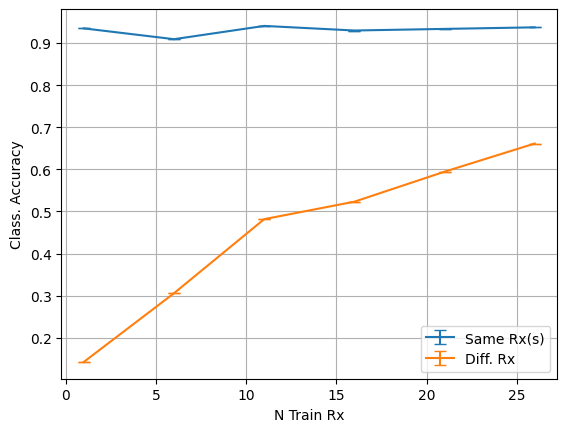

In [ ]:
matplotlib.rcParams['figure.dpi'] = 100
plt.errorbar(np.array(nrx_list)+1,np.mean(smTest_results,0),np.std(smTest_results,0),capsize=4)
plt.errorbar(np.array(nrx_list)+1,np.mean(dfTest_results,0),np.std(dfTest_results,0),capsize=4)
plt.legend(['Same Rx(s)','Diff. Rx'])
plt.xlabel('N Train Rx')
plt.ylabel('Class. Accuracy')
#plt.xticks(range(0,len(nrx_list),2))
plt.grid()
print(np.mean(dfTest_results,0).tolist())

In [ ]:
!cp -r /content/weights /content/drive/MyDrive/resnet/2D